# <center><u><font color="red">Surfs Up!</font></u></center>

### Initial Configuration

In [1]:
#*******************************************************************************
# Dependencies and Setup
#*******************************************************************************
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
#*******************************************************************************
# More Dependencies
#*******************************************************************************
import numpy as np
import pandas as pd

In [3]:
#*******************************************************************************
# datetime Dependency
#*******************************************************************************
import datetime as dt

# Step 1 - Climate Analysis and Exploration

## Reflect Tables into SQLAlchemy ORM

In [4]:
#*******************************************************************************
# Python SQL toolkit and Object Relational Mapper
#*******************************************************************************
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#*******************************************************************************
# Connect to the sqlite database.
#*******************************************************************************
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#*******************************************************************************
# Reflect an existing database into a new model
#*******************************************************************************
Base = automap_base()

#*******************************************************************************
# reflect the tables
#*******************************************************************************
Base.prepare(engine, reflect=True)


In [7]:
#*******************************************************************************
# View all of the classes that automap found
#*******************************************************************************
Base.classes.keys()


['measurement', 'station']

In [8]:
#*******************************************************************************
# Save references to each table
#*******************************************************************************
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
#*******************************************************************************
# Create a session (link) from Python to the DB
#*******************************************************************************
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
#*******************************************************************************
# Create the inspector and connect it to the engine
#*******************************************************************************
inspector = inspect(engine)


In [11]:
#*******************************************************************************
# Collect the names of tables within the database and confirm the 
# "Base.classes.keys()" above.
#*******************************************************************************
inspector.get_table_names()


['measurement', 'station']

In [12]:
#*******************************************************************************
# Use the inspector to print the column names within the 'measurement' table 
# and its types.
#*******************************************************************************
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#*******************************************************************************
# Use the inspector to print the column names within the 'station' table and 
# its types
#*******************************************************************************
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#*******************************************************************************
# Use the session to query the measurement table and display the first row
#*******************************************************************************
print(session.query(Measurement.station, 
                    Measurement.date, 
                    Measurement.prcp).first())


('USC00519397', '2010-01-01', 0.08)


In [15]:
#*******************************************************************************
# Use session to query the measurement table and get the .....
#*******************************************************************************
# for row in session.query(Measurement).\
#     filter(Measurement.date > '2015-08-08').order_by(Measurement.date).all():
#     print(row.date, row.station, row.prcp)

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [16]:
################################################################################
# Calculate the date 1 year ago from the last data point in the database
################################################################################

#*******************************************************************************
# find the newest date (last data point) in the Measurement table
#*******************************************************************************
dt_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print("Newest date in the Measurement table = {}".format(dt_last_date))

#*******************************************************************************
# convert the last date from the Measurement table to a valid date format
#*******************************************************************************
dt_last_date = dt.datetime.strptime(dt_last_date, '%Y-%m-%d')
dt_last_date = dt_last_date.date()

#*******************************************************************************
# find the date one year prior to the oldest date in the table
#*******************************************************************************
one_year_earlier = dt_last_date - dt.timedelta(days=366)
print("one_year_earlier = {}".format(one_year_earlier))


Newest date in the Measurement table = 2017-08-23
one_year_earlier = 2016-08-22


In [59]:
#*******************************************************************************
# Perform a query to retrieve the data and precipitation scores
#*******************************************************************************
# daily_percipitation = session.query(Measurement.date.label('date'), 
#                                     func.sum(Measurement.prcp).label('precipitation')).\
#                                     filter(Measurement.date > "2016-08-22")

daily_percipitation = session.query(Measurement.date, Measurement.prcp).\
                                    filter(Measurement.date > one_year_earlier)

#*******************************************************************************
# Save the query results as a Pandas DataFrame and set the index to the date 
# column
#*******************************************************************************
last_year_precipitation_df = pd.DataFrame(daily_percipitation[366:], 
                                          columns=['date', 'prcp'])

last_year_precipitation_df.set_index('date', inplace=True)
last_year_precipitation_df = last_year_precipitation_df.dropna(how='any')
last_year_precipitation_df = last_year_precipitation_df.sort_values("date", ascending=True)
last_year_precipitation_df.head()


,prcp
date,
2016-08-23,1.79
2016-08-23,0.70
2016-08-23,0.02
2016-08-23,0.05
2016-08-24,2.15


In [60]:
# Set x axis and tick locations
x_axis = np.arange(len(last_year_precipitation_df))
tick_locations = [value for value in x_axis]

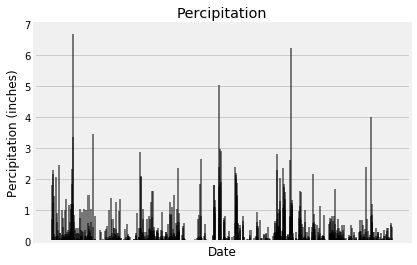

In [61]:
#plt.figure(figsize=(20,5))
plt.bar(x_axis, last_year_precipitation_df["prcp"], color='black', alpha=0.5, align="center", width=10)
plt.xticks([])

# Give our chart some labels and a tile
plt.title("Percipitation")
plt.xlabel("Date")
plt.ylabel("Percipitation (inches)")


#plt.xticks(tick_locations, last_year_precipitation_df["date"], rotation="vertical")
plt.show()

In [62]:
#*******************************************************************************
# Use Pandas to calcualte the summary statistics for the precipitation data
#*******************************************************************************
all_percipitation = session.query(Measurement.date.label("date"), Measurement.prcp).\
                                  filter(Measurement.date > one_year_earlier)

all_percipitation_df = pd.DataFrame(all_percipitation[:], columns=['date', 'prcp'])
all_percipitation_df.set_index('date', inplace=True, )
all_percipitation_df.head()

all_percipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [63]:
#*******************************************************************************
# Design a query to show how many stations are available in this dataset?
#*******************************************************************************
num_stations = session.query(Measurement.station).group_by(Measurement.station).\
               distinct(Measurement.station).count()
print(f'The number of stations is {num_stations}')

The number of stations is 9


In [64]:
#*******************************************************************************
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#*******************************************************************************
station_data = session.query(Measurement.station.label('station'), 
                             Measurement.prcp.label('percipitation'), 
                             func.count(Measurement.station).label('station_count')).\
                             group_by(Measurement.station).\
                             order_by(func.count(Measurement.station).desc())

station_active_df = pd.DataFrame([(d.station, d.station_count) for d in station_data], 
                                      columns=['station', 'station_count'])

station_active_df.head(num_stations)

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [65]:
#*******************************************************************************
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#*******************************************************************************
most_active_station = station_data.first()[0]

most_active_station_summary_data = session.query(func.min(Measurement.tobs), 
                                                 func.max(Measurement.tobs), 
                                                 func.avg(Measurement.tobs)).\
                                                 filter(Measurement.station == most_active_station)

print(f"The most active station is {most_active_station}. For this station:")
print(f"The minimum temperature was {most_active_station_summary_data.first()[0]}.")
print(f"The maximum temperature was {most_active_station_summary_data.first()[1]}.")
print(f"The average temperature was {most_active_station_summary_data.first()[2]}.")


The most active station is USC00519281. For this station:
The minimum temperature was 54.0.
The maximum temperature was 85.0.
The average temperature was 71.66378066378067.


In [66]:
#*******************************************************************************
# Plot the results as a histogram with `bins=12`
#*******************************************************************************
most_active_station_data = session.query(Measurement.station, Measurement.tobs).\
                                    filter(Measurement.date > one_year_earlier).\
                             filter(Measurement.station == most_active_station)

most_active_station_df = pd.DataFrame([(d.station, d.tobs) for d in most_active_station_data], 
                                      columns=['station', 'tobs'])

most_active_station_df.head()


,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


In [67]:
# # Choose the station with the highest number of temperature observations.
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# # Create the bins in which Data will be held
# bins = [0, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 85]

# # Create the labels for the bins
# group_labels = []

In [68]:
# Get the ages of the unique players
temp_only_df = most_active_station_df.loc[:, ["tobs"]]

# Convert the Age to a number
temp_only_df["tobs"] = pd.to_numeric(temp_only_df["tobs"])

# Display the table of ages
temp_only_df.head()

#temp_only_df["Temp Summary"] = pd.cut(temp_only_df["tobs"], bins, right=False)
#temp_only_df = temp_only_df.groupby("Temp Summary").count()
#temp_df = temp_only_df.rename(columns={"tobs":"Total Count"})

temp_only_df.head()


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


In [69]:
# # Use DataFrame.plot() in order to create a bar chart of the data
# temp_only_df.plot(kind="bar", width=1.0)
# # plt.xticks([60, 65, 70, 75, 80])

# plt.ylabel("Frequency")


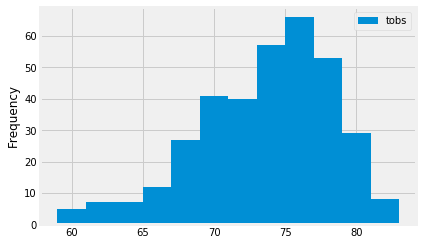

In [70]:
#temp_df.plot.hist(bins=12, alpha=1)
temp_only_df[["tobs"]].plot(kind="hist", bins=12)

#plt.xticks([60, 65, 70, 75, 80])

#temp_df.Series([0, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 85]).hist(bins=12, range=(55, 85)).figure

plt.show()

In [71]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(one_year_earlier)
print(dt_last_date)
print(calc_temps('2017-02-15', '2017-03-0'))

2016-08-22
2017-08-23
[(61.0, 70.46511627906976, 77.0)]


In [73]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_data = calc_temps('2017-02-15', '2017-03-0')
print(temp_data[0][0])
print(temp_data[0][1])
print(temp_data[0][2])
temp_min = temp_data[0][0]
temp_err = temp_data[0][1]
temp_max = temp_data[0][2]

# n_groups = 1

# means_men = (temp_max)
# std_men = (temp_err)

# fig, ax = plt.subplots()

# index = np.arange(n_groups)
# bar_width = 0.10

# opacity = 0.4
# error_config = {'ecolor': '0.3'}

# rects1 = ax.bar(index, means_men, bar_width,
#                 alpha=opacity, color='b',
#                 yerr=std_men, error_kw=error_config,
#                 label='Men')

# #ax.set_xlabel('Group')
# ax.set_ylabel('Scores')
# #ax.set_title('Scores by group and gender')
# #ax.set_xticks(index + bar_width / 2)
# #ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
# ax.legend()

# fig.tight_layout()
# plt.show()


61.0
70.46511627906976
77.0


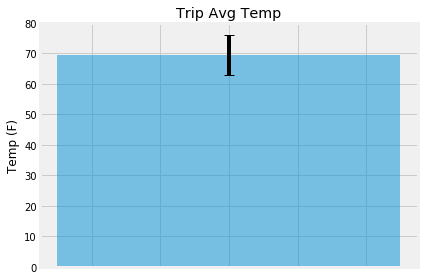

In [77]:
# Data
temp = temp_data


# Calculate the average
temp_mean = np.mean(temp)

# Calculate the standard deviation
temp_std = np.std(temp)


# Define labels, positions, bar heights and error bar heights
labels = ['x_temp']
x_pos = np.arange(len(labels))
tmean = [temp_mean]
error = [temp_std]
bar_width = 0.00001

#In [3]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, tmean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5, 
       width=1)

#ax.set_xticks('x_pos')
ax.set_xticklabels(labels)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the 
# previous year's matching dates. Sort this in descending order by precipitation 
# amount and list the station, name, latitude, longitude, and elevation
station_prcp_data = session.query(Measurement.station.label('station'), 
                                  Measurement.prcp.label('percipitation'), 
                                  func.sum(Measurement.prcp).label('total_prcp')).\
                                  group_by(Measurement.station).\
                                  order_by(func.sum(Measurement.prcp).desc())

# station_active_df = pd.DataFrame([(d.station, d.station_count) for d in station_prcp_data], 
#                                       columns=['station', 'station_count'])
# station_prcp_total_df = pd.DataFrame([station_prcp_data])

# station_prcp_total_df.head(num_stations)

print(station_prcp_data.all())

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
